In [43]:
import time
import numpy as np
import pandas as pd
import csv
from datetime import datetime,timedelta
data_path = 'D:\\human-queue-data\\'
feature=['age_at_study_date','tea_year','alcohol_category','smoking_category','met_hours','standing_height_mm','waist_mm','has_diabetes','is_female','hypertension_diag','waist_mm','hip_mm','bmi_calc']
data=pd.read_csv(data_path+'baseline.txt',sep = '\t', usecols = feature)
# ,sep = '\t', usecols = feature
# data=data.head(20000)
print(data.columns)
data.dropna().describe().to_csv('./temp2.csv')

Index(['is_female', 'age_at_study_date', 'tea_year', 'alcohol_category',
       'smoking_category', 'has_diabetes', 'hypertension_diag', 'met_hours',
       'standing_height_mm', 'waist_mm', 'hip_mm', 'bmi_calc'],
      dtype='object')


PermissionError: [Errno 13] Permission denied: './temp2.csv'

In [44]:
def sb(inp,num):
    if(inp>num):
        return 1
    else :
        return 0

data['drink_tea'] = data.apply(lambda row: sb(row['tea_year'],0), axis=1)
data['drink_alcohol'] = data.apply(lambda row: sb(row['alcohol_category'],1), axis=1)
data['is_smokker'] = data.apply(lambda row: sb(row['smoking_category'],1), axis=1)
data['waist_kg'] = data['waist_mm']/10
data['standing_height_cm'] = data['standing_height_mm']/10
data['waist_cm']=data['waist_mm']/10
data['hip_cm']=data['hip_mm']/10

data.drop(['standing_height_mm','waist_mm','smoking_category','alcohol_category','tea_year','waist_mm','hip_mm'],axis=1,inplace=True)
common_feature=['age_at_study_date','drink_tea','drink_alcohol','is_smokker','met_hours','standing_height_cm','waist_kg','is_female']

data.to_csv('./health.csv')


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn2pmml import PMMLPipeline, sklearn2pmml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report
from sklearn.grid_search import GridSearchCV

num_features = data.shape[0]
print("Number of all features: \t\t", num_features)
split = int(num_features * 5/6)

train = data[:split]
test = data[split:]

train_1=train[train['has_diabetes']==0].head(40000)
train_2=train[train['has_diabetes']==1]
re=train_1.append(train_2)
print("Number of features used for training: \t", len(train),
      "\nNumber of features used for testing: \t", len(test))

# 开始使用随机森林分类器
clf = RandomForestClassifier(n_estimators=94,max_depth=5, min_samples_split=150) # 定义决策树的个数为100

model = clf.fit(re[common_feature], re['has_diabetes'])

output = model.predict(test[common_feature])
print(classification_report(test['has_diabetes'], output))

# fpr,tpr,threshold = roc_curve(test['has_diabetes'], score) ###计算真正率和假正率
# roc_auc = auc(fpr,tpr)

# plt.figure()
# lw = 2
# plt.figure(figsize=(10,10))
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic ')
# plt.legend(loc="lower right")
# plt.show()


# y_predprob = clf.predict_proba(X)[:,1]
# print "AUC Score (Train): %f" % metrics.roc_auc_score(y,y_predprob)

# acc = np.mean(output == test['has_diabetes']) *100
# print("The accuracy of the pure RandomForest classifier is: \t", acc, "%")
# fig, ax = plt.subplots(figsize=(12,18))
# clf.feature_importances_
# ax.grid(False)
# plt.title("LightGBM - Feature Importance", fontsize=15)
# plt.show()

# param_test1= {'n_estimators':[x for x in range(50,200,2)]}
# gsearch1= GridSearchCV(estimator = RandomForestClassifier(
#                                  max_depth=5,
#                                  min_samples_leaf=20,max_features='sqrt' ,random_state=10),
#                        param_grid =param_test1, scoring='roc_auc',cv=5)
# gsearch1.fit(train[common_feature], train['has_diabetes'])
# gsearch1.grid_scores_,gsearch1.best_params_, gsearch1.best_score_



Number of all features: 		 512891
Number of features used for training: 	 427409 
Number of features used for testing: 	 85482
             precision    recall  f1-score   support

          0       0.96      0.85      0.90     80434
          1       0.15      0.42      0.22      5048

avg / total       0.91      0.82      0.86     85482



[0.         0.15030957 1.        ]
[0.42432647 1.         1.        ]


<Figure size 432x288 with 0 Axes>

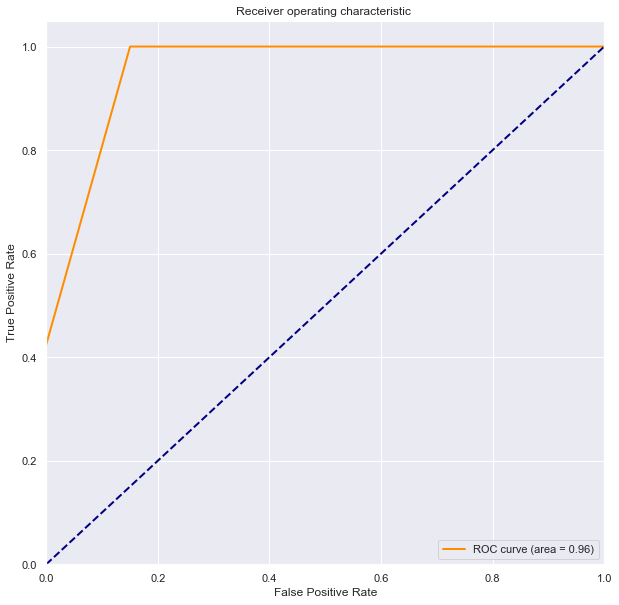

In [53]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test['has_diabetes'], test['has_diabetes']+output, pos_label=1)
# fpr,tpr,threshold = roc_curve(test['has_diabetes'], score) ###计算真正率和假正率
roc_auc = auc(fpr,tpr)
print (fpr)
print (tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

In [ ]:

diabete_pipeline = PMMLPipeline([
 ("classifier", RandomForestClassifier())
])
 
# 训练模型
diabete_pipeline.fit(data[common_feature], data['has_diabetes'])
 
# 导出模型到 RandomForestClassifier_Iris.pmml 文件
sklearn2pmml(diabete_pipeline, "RandomForestClassifier_diabete.pmml")

In [4]:
hypertension_pipeline = PMMLPipeline([
 ("classifier", RandomForestClassifier())
])
 
# 训练模型
hypertension_pipeline.fit(data[common_feature], data['hypertension_diag'])
 
# 导出模型到 RandomForestClassifier_Iris.pmml 文件
sklearn2pmml(hypertension_pipeline, "RandomForestClassifier_hypertension.pmml")

In [10]:
Aa=pd.read_csv('./health.csv')
Aa.drop(['has_diabetes','hypertension_diag','drink_tea','is_smokker','waist_cm'],axis=1,inplace=True)
Aa.head(10)
Aa.dropna().to_csv('./health.csv',index = False)


In [11]:
Aa=pd.read_csv('./health.csv')
# Aa.drop(['Unnamed: 0'])
Aa.head(10)

,is_female,age_at_study_date,has_diabetes,hypertension_diag,met_hours,bmi_calc,drink_tea,drink_alcohol,is_smokker,waist_kg,standing_height_cm,waist_cm,hip_cm
0,1,46,0,0,12.35,20.4,0,0,0,70.0,163.1,70.0,88.5
1,1,50,0,0,2.00,22.7,1,0,0,76.2,151.8,76.2,91.6
2,1,71,0,0,3.00,30.3,1,0,0,92.0,151.3,92.0,96.5
3,0,60,0,0,5.00,23.9,1,0,1,79.2,155.0,79.2,86.0
4,0,75,0,1,0.71,22.0,0,0,1,82.0,161.2,82.0,86.8
5,1,53,0,0,10.75,20.5,1,1,0,68.7,143.9,68.7,80.8
6,0,41,0,0,12.00,24.0,1,1,1,75.0,165.9,75.0,89.0
7,1,57,1,0,5.00,24.2,0,0,0,82.0,153.6,82.0,86.7
8,1,39,0,0,3.67,28.0,0,1,0,85.2,156.1,85.2,94.4
9,0,41,0,0,8.67,20.9,1,0,1,74.2,156.3,74.2,82.5


In [7]:
Aa[Aa['age_at_study_date']<35].min()

Unnamed: 0             75.0
is_female               0.0
age_at_study_date      30.0
has_diabetes            0.0
hypertension_diag       0.0
met_hours               0.0
bmi_calc               15.8
drink_tea               0.0
drink_alcohol           0.0
is_smokker              0.0
waist_kg               58.0
standing_height_cm    139.1
waist_cm               58.0
hip_cm                 68.5
dtype: float64